# Explore here

In [11]:
# Your code here

- **DATA FROM** -> https://www.kaggle.com/c/dogs-vs-cats/data

Getting dog and cat images, since our data is a folder full of pictures of dogs and cats we'll create two subdirectories and group the images in them, then delete the pictures outside the subdirectories

In [12]:
import os
import shutil
from tensorflow import keras

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

path = "../data/raw/train"

bark_bark_folder = os.path.join(path, "dog")
meow_meow_folder = os.path.join(path, "cat")

os.makedirs(bark_bark_folder, exist_ok = True)
os.makedirs(meow_meow_folder, exist_ok = True)

for pic in os.listdir(path):
    pic_path = os.path.join(path, pic)
 
    if os.path.isfile(pic_path):
        if "dog" in pic:
            shutil.move(pic_path, os.path.join(bark_bark_folder, pic))
        elif "cat" in pic:
            shutil.move(pic_path, os.path.join(meow_meow_folder, pic))
        if os.path.exists(pic_path):
            os.remove(pic_path)

dog_images = os.listdir(bark_bark_folder)
cat_images = os.listdir(meow_meow_folder)

We've separated dog and cat images

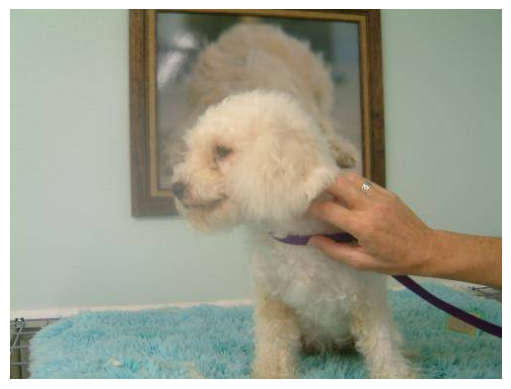

In [13]:
import matplotlib.pyplot as plt
from PIL import Image

dog_image = os.path.join(bark_bark_folder, dog_images[0])

img = Image.open(dog_image)
plt.imshow(img)
plt.axis("off")
plt.show()

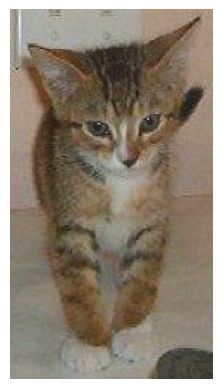

In [14]:
cat_image = os.path.join(meow_meow_folder, cat_images[0])

img = Image.open(cat_image)
plt.imshow(img)
plt.axis("off")
plt.show()

Now we'll fix the size of the pictures to 200x200px and show 9 of each set

DOGS

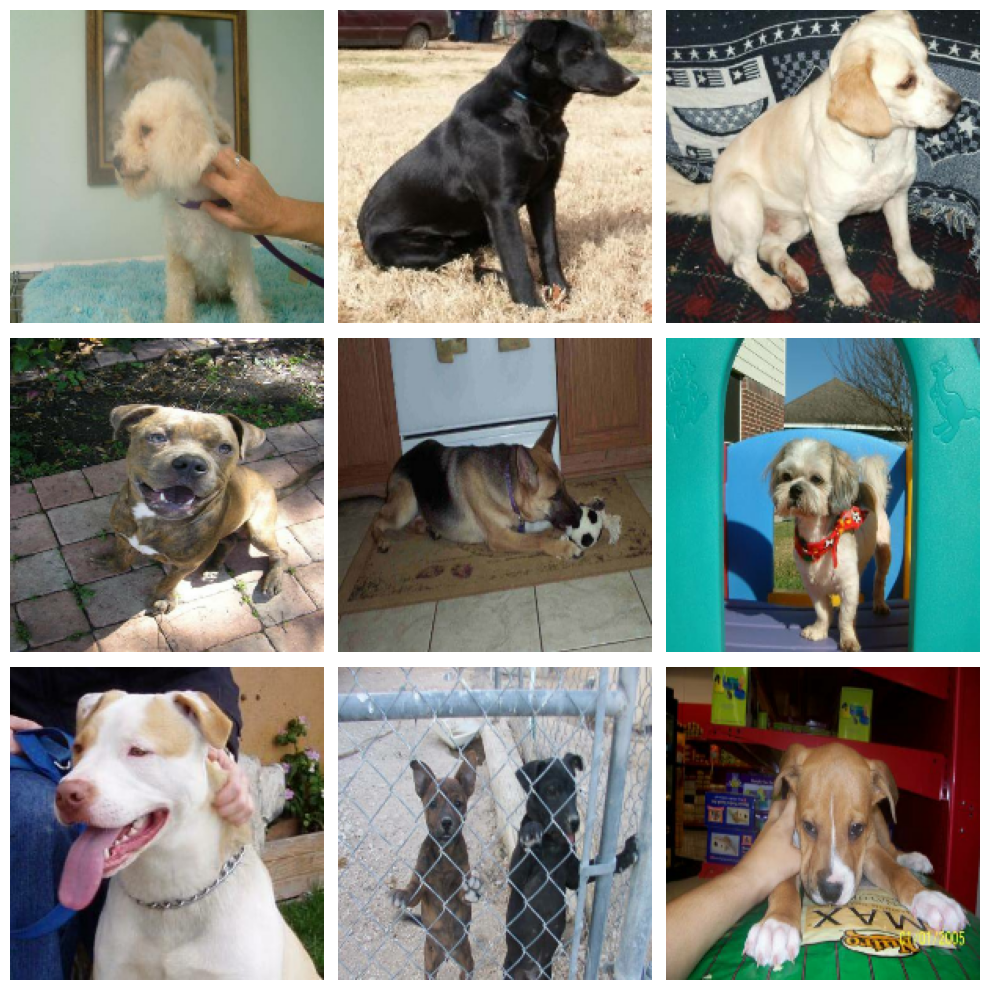

In [15]:
import tensorflow as tf
import numpy as np

dog_image_to_show = []
for pic in range(9):
    dog_image = os.path.join(bark_bark_folder, dog_images[pic])
    img = tf.io.read_file(dog_image)
    img = tf.image.decode_jpeg(img, channels = 3)
    img_resized = tf.image.resize(img, [200, 200])
    dog_image_to_show.append(img_resized)

fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for ax, pic in zip(axes.flatten(), dog_image_to_show):

    if isinstance(pic, tf.Tensor):  
        pic = pic.numpy()

    img = Image.fromarray(pic.astype(np.uint8))
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout()
plt.show()


CATS

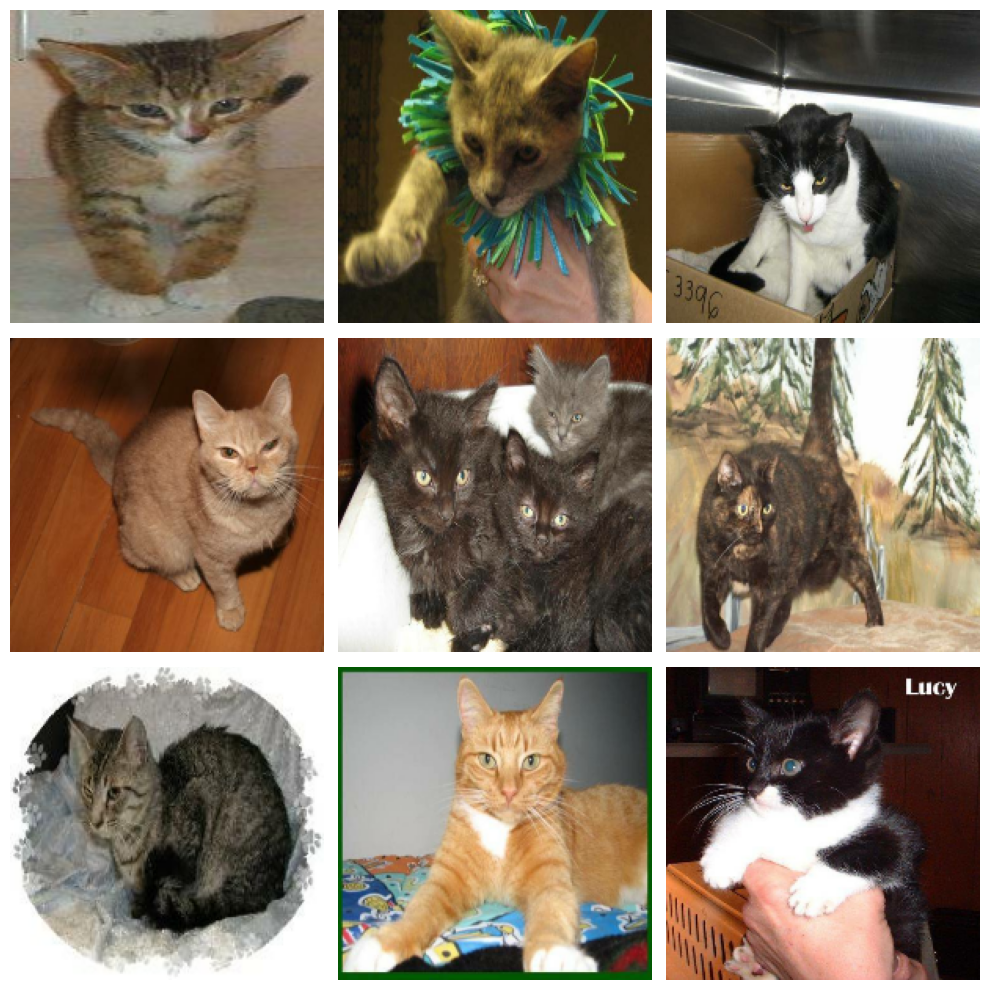

In [16]:
cat_image_to_show = []
for pic in range(9):
    cat_image = os.path.join(meow_meow_folder, cat_images[pic])
    img = tf.io.read_file(cat_image)
    img = tf.image.decode_jpeg(img, channels = 3)
    img_resized = tf.image.resize(img, [200, 200])
    cat_image_to_show.append(img_resized)

fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for ax, pic in zip(axes.flatten(), cat_image_to_show):

    if isinstance(pic, tf.Tensor):  
        pic = pic.numpy()

    img = Image.fromarray(pic.astype(np.uint8))
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout()
plt.show()

- Resizing all the pictures to 200x200px and creating training and testing data

Since codespace doesn't have more than 12GB of RAM, we'll load the images progressively using the Keras **ImageDataGenerator** class and the **flow_from_directory()** function. This will be slower to run but it will run on less capable hardware. This function prefers the data to be split into separate train and test directories, and under each directory to have a subdirectory for each class.

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

training_data = ImageDataGenerator(validation_split=0.2)
testing_data = ImageDataGenerator()

train_data = training_data.flow_from_directory(path, batch_size=10, target_size = (200, 200), classes = ["dog", "cat"], class_mode="categorical")

test_data = testing_data.flow_from_directory("../data/raw", batch_size=10, target_size = (200, 200), classes = ["test1"], class_mode="categorical")

val_data = training_data.flow_from_directory(path, batch_size=10, target_size=(200, 200), classes=["dog", "cat"], subset="validation")

Found 25000 images belonging to 2 classes.


Found 13721 images belonging to 1 classes.
Found 5000 images belonging to 2 classes.


- **MODEL TRAINING**

In [18]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, Dropout

model = Sequential()

model.add(InputLayer(input_shape=(200, 200, 3)))

model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())

model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=2, activation="softmax"))

/home/vscode/.local/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [19]:
from keras.optimizers import Adam

model.compile(loss = keras.losses.categorical_crossentropy, optimizer = Adam(learning_rate=0.0001), metrics = ["accuracy"])
model

<Sequential name=sequential_1, built=True>

In [20]:
model.fit(train_data, epochs=1)

/home/vscode/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1141s 456ms/step - accuracy: 0.6279 - loss: 2.4979


In [21]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("../models/best_model.h5", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

early_stopping = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto", verbose=1)

history = model.fit(train_data, steps_per_epoch = 75, epochs=5, validation_data=val_data, callbacks=[checkpoint, early_stopping])

Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.7377 - loss: 0.4741

/home/vscode/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.78420, saving model to ../models/best_model.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.7379 - loss: 0.4745 - val_accuracy: 0.7842 - val_loss: 0.4804
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.7554 - loss: 0.5032
Epoch 2: val_accuracy did not improve from 0.78420
75/75 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.7554 - loss: 0.5031 - val_accuracy: 0.7474 - val_loss: 0.5071
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.7462 - loss: 0.5117
Epoch 3: val_accuracy improved from 0.78420 to 0.79740, saving model to ../models/best_model.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.7465 - loss: 0.5115 - val_accuracy: 0.7974 - val_loss: 0.4564
Epoch 4/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.7627 - loss: 0.4867
Epoch 4: val_accuracy did not improve from 0.79740
75/75 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.7629 - loss: 0.4867 - val_accuracy: 0.7910 - val_loss: 0.4595
Epoch 5/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.7433 - loss: 0.5221
Epoch 5: val_accuracy did not improve from 0.79740
75/75 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.7433 - loss: 0.5222 - val_accuracy: 0.6932 - val_loss: 0.5690


In [22]:
model.save("../models/pred_model.h5")

- **IMAGE PREDICTION**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
THIS THING BARKS ..SO IT'S A DOG


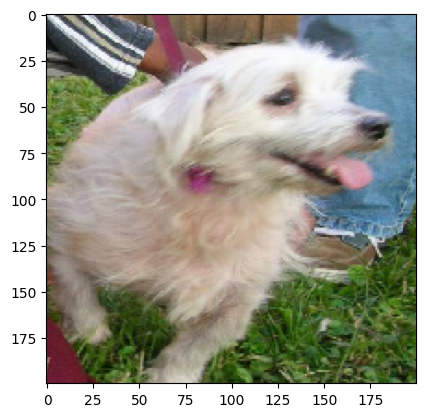

In [24]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

model = load_model("../models/pred_model.h5")

img = image.load_img("../data/raw/train/dog/dog.9.jpg", target_size=(200, 200))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

predictions = model.predict(img_array)

if predictions[0][0] > predictions[0][1]:
    print("THIS THING BARKS ..SO IT'S A DOG")
else:
    print("THIS THING MEOWS ..SO IT'S A CAT")

plt.imshow(img)